In [1]:
from pathlib import Path
import pyart



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

from prepro.nexrad import prune_nexrad

#viewable plots
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_zdr_cmap
from config import _EXAMPLEDATA_DIR



In [3]:
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KUDX20150620_040849_V06.gz')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KOAX20140603_213649_V06.gz')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KEWX20210504_020040_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KSHV20230613_230228_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KTLX20160526_215113_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KTLX20200422_023145_V06')
#read in the Level 2 WSR-88D data as a pyart object
radar_vol = pyart.io.read_nexrad_archive(filename)
radar_vol.info()


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (9720,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (9720,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (9720, 1832)>
		units: dB
		standard_name: log_differential_reflectivity_hv
		long_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differenti

In [4]:
#remove extra sweeps of data. Keep only data
#from the survelience cuts and one cut per volume 
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)

#from hotspots.io.radarinfo import get_project_root, read_nexrad_radarinfo
#print(get_project_root())
#radar_info = read_nexrad_radarinfo()
#print(radar_info)


In [5]:
#w_phase = pyart.correct.unwrap.dealias_unwrap_phase(prune_vol, unwrap_unit='volume')
#rune_vol.add_field("unwrapped_differential_phase", uw_phase)
prune_vol.info()


altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (6120,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (6120, 1832)>
		units: dB
		standard_name: log_differential_reflectivity_hv
		long_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differenti

In [6]:
#
#Eventually our goal here is to create the entire ORPG PreProcessor stack.
#
#basic plan:
#    compute 1d texture of Z using 5 gates (use in HCA)
#    compute 1d texture of Phase using 9 gates (used in HCA)
#
#    compute 1d averages 3 Gate Z
#    compute 1d average 5 gate Zdr,CC
#    
#    We do not dealias velocity in this code. 
#    Spectrum Width is not modified in this code
#
#    compute the Signal-to_Noise Ratio (SNR) variable
#    compute the smoothed_Phase variable, which is the key 
#        input to KDP
#    compute the specific differential phase (KDP) variable
#  
#    correct Z for horizontal attenuation
#    correct Zdr for horizontal attenuation
#
#For use by phased array radars, which are not sweep/elevation mode
#or by RHI radars, we process the data one ray at a time.
#this requires that we know the min_system_phase before we start
#
#Our Pyart driver:
from prepro.process_phase import *
from prepro.prepro_helpers import *
radar_vol = prune_vol
sweeps = radar_vol.sweep_number['data']

#extract a sweep of phi and rhv

#print('working...will notify at end')
si= 100
ei = 200
ia = 528

#check for matching azimuth in rhv_field and adjust it to match the phi_field
#right now assume they match in azimuth
   

z_field = copy.deepcopy(radar_vol.fields['reflectivity'])
cc_field = copy.deepcopy(radar_vol.fields['cross_correlation_ratio'])
zdr_field = copy.deepcopy(radar_vol.fields['differential_reflectivity'])
phase_field = copy.deepcopy(radar_vol.fields['differential_phase'])
vel_field = copy.deepcopy(radar_vol.fields['velocity'])
snr_field = copy.deepcopy(radar_vol.fields['differential_reflectivity'])

num_az, num_gates = z_field['data'].shape

missing_value = z_field["_FillValue"]

print('num_az: ', num_az, ' num_gates: ', num_gates, ' missing: ', missing_value)
#create the output structure:
output = copy.deepcopy(radar_vol)

metadata = {}
#metadata['radar_Frequency_in_MHz'] = #need help here.... where is this in the pyart radar object?

metadata['gatespacing_meters'] = radar_vol.range['meters_between_gates']
metadata['distance_to_first_gate_meters'] = radar_vol.range['meters_to_center_of_first_gate']
metadata['C'] = 40.0 #need help here.... where is this in the pyart radar object?
metadata['phase_wrap_in_degrees'] = radar_vol.fields['differential_phase']['valid_max']
metadata['radar_frequency_MHz'] = 2705.0 #KOUN Freq
metadata['zdr_absolute_calibration'] = 0.0
metadata['z_absolute_calibration'] = 0.0
metadata['phase_window'] = 9
metadata['compute_kdp'] = False #Too slow to be workable. 
metadata['ngates'] = num_gates
#metadata['parallel'] = True


for s in range(len(sweeps)):
    #which data do we use?
    start_index, end_index = radar_vol.get_start_end(s)
    num_az_s = end_index-start_index
    print(s, 'sweep_num: ', sweeps[s], 'start: ', start_index, ' end: ', end_index)
    #our output target
    
    #for convienece we use elevations of data.
    #you could push the input data in one ray at a time, but that requires knowing 
    #min_system_phase, which you can compute in advance, or have in metadata
    
    z_data = z_field['data'][start_index:end_index]
    cc_data = cc_field['data'][start_index:end_index]
    zdr_data = zdr_field['data'][start_index:end_index]
    phase_data = phase_field['data'][start_index:end_index]
    v_data =vel_field['data'][start_index:end_index]

    elevation = radar_vol.elevation['data'][start_index:end_index] #elevation for each ray
    azimuth = radar_vol.azimuth['data'][start_index:end_index]
    zdr_calibration = metadata['zdr_absolute_calibration']
    z_calibration = metadata['z_absolute_calibration']
    #
    #returned data
    #
    prepro_z_data = np.empty([num_az_s, num_gates]) * np.nan
    prepro_cc_data = np.empty([num_az_s, num_gates]) * np.nan
    prepro_zdr_data = np.empty([num_az_s, num_gates]) * np.nan
    prepro_phase_data = np.empty([num_az_s, num_gates]) * np.nan
    prepro_kdp_data = np.empty([num_az_s, num_gates]) * np.nan
    
    prepro_v_data = np.empty([num_az_s, num_gates]) * np.nan
    prepro_snr_data = np.empty([num_az_s, num_gates]) * np.nan
        
    prepro_textureZ = np.empty([num_az_s, num_gates]) * np.nan
    prepro_texturePhase = np.empty([num_az_s, num_gates]) * np.nan
    
    #### preprocessor start's here ####
    debug=False
    #correct phase for radar frequency difference to KTLX: (not implemented) 
    # Dusan Zurnic, NSSL recommends that the radar frequency differenct be accounted for because
    # the corrections for horizontal attenuation are based/developed on the KTLX frequency
    #min_system_phase = compute_min_system_phase(phase_data, cc_data)
    #correct the phase to a minuimum value of zero, uses the elevation to find the min_system_phase
    
    prepro_phase_data = process_differential_phase (phase_data, cc_data)
    
    for a in range(0, end_index-start_index):
        metadata['elev'] = elevation[a]
        metadata['az'] = azimuth[a]
        
    #Test for single radial processing    
        #prepro_phase_data[a] = process_differential_phase (phase_data[a], cc_data[a], 
        #                                                   phase_window=metadata['phase_window'], min_system_phase=min_system_phase)
        
    #calculate the texture fields, used in HCA
        prepro_textureZ[a] = calc_std_texture_nORPG(z_data[a], 5, debug)
        prepro_texturePhase[a] = calc_std_texture_nORPG(phase_data[a], 9, debug)
    
    #calculate the smoothed (radial directioin only) dualpol
    #data, to reduce the noise
        prepro_z_data[a] = local_running_ave_1D(z_data[a], 3, debug)
        prepro_v_data[a] = local_running_ave_1D(v_data[a], 5, debug)
        prepro_zdr_data[a] = local_running_ave_1D(zdr_data[a], 5, debug)
        prepro_cc_data[a] = local_running_ave_1D(cc_data[a], 5, debug)

    #compute the SNR
        prepro_snr_data[a] = compute_SNR_nORPG(prepro_z_data[a],
                                               elevation[a], metadata)
        
    #correct for horizontal attenuation
        prepro_zdr_data[a] += prepro_phase_data[a]*0.004
        prepro_z_data[a] += prepro_phase_data[a]*0.04
    
    #perform absolute calibration
        prepro_zdr_data[a] += zdr_calibration
        prepro_z_data[a] += z_calibration
    
    #calculate kdp as the slope of smoothed phi. If you don't like the kdp
    #computation, change process_differential_phase not this.
        if metadata['compute_kdp']:
            prepro_kdp_data[a] = calc_kdp_1D(metadata, prepro_phase_data[a], 9, debug)
            
    z_field['data'][start_index:end_index][:] = prepro_z_data[:]
    cc_field['data'][start_index:end_index][:] = prepro_cc_data
    zdr_field['data'][start_index:end_index][:]= prepro_zdr_data
    phase_field['data'][start_index:end_index][:] = prepro_phase_data
    vel_field['data'][start_index:end_index][:] = prepro_v_data
    snr_field['data'][start_index:end_index][:] = prepro_snr_data

output.add_field('prepro_zh', z_field)
output.add_field('prepro_cc', cc_field)
output.add_field('prepro_zdr', zdr_field)
output.add_field('prepro_phase', phase_field)
output.add_field('prepro_v', vel_field)
output.add_field('prepro_snr', snr_field)


num_az:  6120  num_gates:  1832  missing:  -9999.0
0 sweep_num:  0 start:  0  end:  719
1 sweep_num:  1 start:  720  end:  1439
2 sweep_num:  2 start:  1440  end:  2159
3 sweep_num:  3 start:  2160  end:  2519
4 sweep_num:  4 start:  2520  end:  2879
5 sweep_num:  5 start:  2880  end:  3239
6 sweep_num:  6 start:  3240  end:  3599
7 sweep_num:  7 start:  3600  end:  3959
8 sweep_num:  8 start:  3960  end:  4319
9 sweep_num:  9 start:  4320  end:  4679
10 sweep_num:  10 start:  4680  end:  5039
11 sweep_num:  11 start:  5040  end:  5399
12 sweep_num:  12 start:  5400  end:  5759
13 sweep_num:  13 start:  5760  end:  6119


In [7]:

#prune_vol.add_field('unwrapped_phi_simple', uw_phi_simple)
output.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (6120,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	differential_reflectivity:
		data: <ndarray of type: float32 and shape: (6120, 1832)>
		units: dB
		standard_name: log_differential_reflectivity_hv
		long_name: log_differential_reflectivity_hv
		valid_max: 7.9375
		valid_min: -7.875
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	differenti

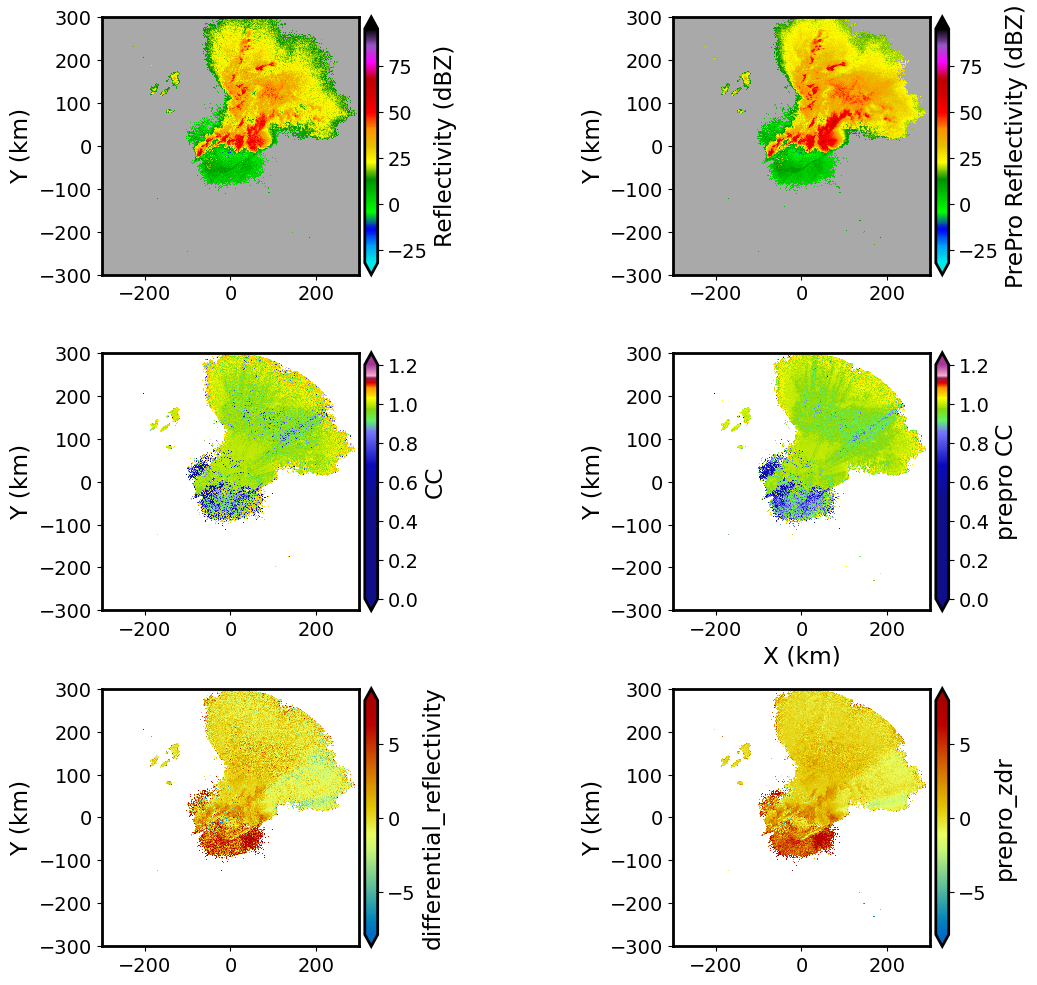

In [8]:
from klaus_krause_cmap import *

fig = plt.figure(figsize=(12, 10))

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )


xlim = [-300, 300]
ylim = [-300, 300]
axislabels=["X (km)", "Y (km)"]


sweep = 0
display = pyart.graph.RadarDisplay(output)


ax1 = fig.add_subplot(321)
ax1.set_aspect('equal')
ax1.set_facecolor('darkgrey')


display.plot_ppi(
        "reflectivity", sweep=sweep, ax=ax1, vmin=-32, vmax=95,
        mask_outside=True, cmap="pyart_NWSRef", title_flag=False,
        colorbar_label='Reflectivity (dBZ)', colorbar_flag=False, axislabels=axislabels )

display.set_limits(xlim, ylim, ax=ax1)
#display.plot_range_rings([50, 100, 150], ax=ax1, lw=1.0, ls='--', col='black')

display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='Reflectivity (dBZ)')
#
#no figure labels for paper. Information is in the
#figure caption
#
#ax1.set_title(f"Reflectivity {radarname} {cappi_time:%Y-%m-%d %H:%M}")
ax1.set_xlabel('')
ax1.set_ylabel('Y (km)')

ax2 = fig.add_subplot(322)
ax2.set_aspect('equal')
ax2.set_facecolor('darkgrey')


display.plot_ppi(
        "prepro_zh", sweep=sweep, ax=ax2, vmin=-32, vmax=95,
        mask_outside=True, cmap="pyart_NWSRef", title_flag=False,
        colorbar_label='Reflectivity (dBZ)', colorbar_flag=False, axislabels=axislabels )

display.set_limits(xlim, ylim, ax=ax2)
#display.plot_range_rings([50, 100, 150], ax=ax1, lw=1.0, ls='--', col='black')

display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='PrePro Reflectivity (dBZ)')
#
#no figure labels for paper. Information is in the
#figure caption
#
#ax1.set_title(f"Reflectivity {radarname} {cappi_time:%Y-%m-%d %H:%M}")
ax2.set_xlabel('')
ax2.set_ylabel('Y (km)')


ax3 = fig.add_subplot(323)
ax3.set_aspect('equal')
CC_cmap = get_cc()



display.plot(
        "cross_correlation_ratio", sweep=sweep, ax=ax3, vmin=0, vmax=1.2,
        cmap='NWS_CC', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax3)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='CC')

ax3.set_xlabel('')
ax3.set_ylabel('Y (km)')

ax4 = fig.add_subplot(324)
ax4.set_aspect('equal')


display.plot(
        "prepro_cc", sweep=sweep, ax=ax4, vmin=0, vmax=1.2,
        cmap='NWS_CC', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax4)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='prepro CC')

ax5 = fig.add_subplot(325)
ax5.set_aspect('equal')


display.plot(
        "differential_reflectivity", sweep=sweep, ax=ax5, 
        cmap='pyart_HomeyerRainbow', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax5)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='differential_reflectivity')

ax5.set_xlabel('')
ax5.set_ylabel('Y (km)')

ax6 = fig.add_subplot(326)
ax6.set_aspect('equal')


display.plot(
        "prepro_zdr", sweep=sweep, ax=ax6, 
        cmap='pyart_HomeyerRainbow', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax6)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='prepro_zdr')

ax6.set_xlabel('')
ax6.set_ylabel('Y (km)')

plt.tight_layout()
plt.show()
plt.close(fig)




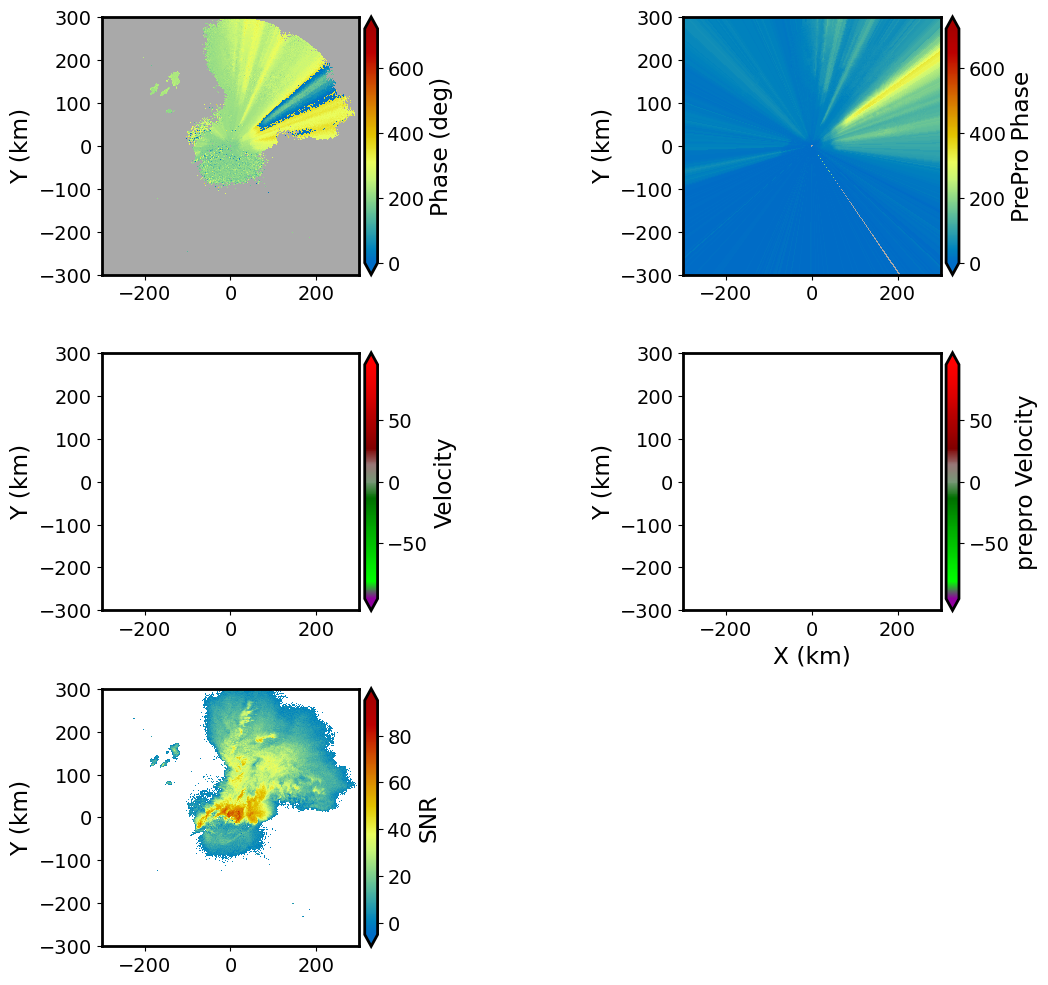

In [9]:
from klaus_krause_cmap import *

fig = plt.figure(figsize=(12, 10))

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )


xlim = [-300, 300]
ylim = [-300, 300]
axislabels=["X (km)", "Y (km)"]


sweep = 0
display = pyart.graph.RadarDisplay(output)


ax1 = fig.add_subplot(321)
ax1.set_aspect('equal')
ax1.set_facecolor('darkgrey')


display.plot_ppi(
        "differential_phase", sweep=sweep, ax=ax1, vmin=0, vmax=720,
        mask_outside=True, cmap="pyart_HomeyerRainbow", title_flag=False,
        colorbar_label='Differential Phase', colorbar_flag=False, axislabels=axislabels )

display.set_limits(xlim, ylim, ax=ax1)
#display.plot_range_rings([50, 100, 150], ax=ax1, lw=1.0, ls='--', col='black')

display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='Phase (deg)')
#
#no figure labels for paper. Information is in the
#figure caption
#
#ax1.set_title(f"Reflectivity {radarname} {cappi_time:%Y-%m-%d %H:%M}")
ax1.set_xlabel('')
ax1.set_ylabel('Y (km)')

ax2 = fig.add_subplot(322)
ax2.set_aspect('equal')
ax2.set_facecolor('darkgrey')


display.plot_ppi(
        "prepro_phase", sweep=sweep, ax=ax2, vmin=0, vmax=720,
        mask_outside=True, cmap="pyart_HomeyerRainbow", title_flag=False,
        colorbar_label='Phase (deg)', colorbar_flag=False, axislabels=axislabels )

display.set_limits(xlim, ylim, ax=ax2)
#display.plot_range_rings([50, 100, 150], ax=ax1, lw=1.0, ls='--', col='black')

display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='PrePro Phase')
#
#no figure labels for paper. Information is in the
#figure caption
#
#ax1.set_title(f"Reflectivity {radarname} {cappi_time:%Y-%m-%d %H:%M}")
ax2.set_xlabel('')
ax2.set_ylabel('Y (km)')


ax3 = fig.add_subplot(323)
ax3.set_aspect('equal')
CC_cmap = get_cc()



display.plot(
        "velocity", sweep=sweep, ax=ax3,
        cmap='NWSVel', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax3)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='Velocity')

ax3.set_xlabel('')
ax3.set_ylabel('Y (km)')

ax4 = fig.add_subplot(324)
ax4.set_aspect('equal')


display.plot(
        "prepro_v", sweep=sweep, ax=ax4, vmin=-95, vmax=95,
        cmap='NWSVel', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax4)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='prepro Velocity')

ax5 = fig.add_subplot(325)
ax5.set_aspect('equal')


display.plot(
        "prepro_snr", sweep=sweep, ax=ax5, vmin=-5, vmax=95,
        cmap='pyart_HomeyerRainbow', mask_outside=True, title_flag=False,
        colorbar_label='', colorbar_flag=False, axislabels=axislabels)
display.set_limits(xlim, ylim, ax=ax5)
#display.plot_range_rings([50, 100, 150], ax=ax2, lw=1.0, ls='--', col='black')
display.plot_colorbar(extend='both', pad=0.01, shrink=1.0, label='SNR')

ax5.set_xlabel('')
ax5.set_ylabel('Y (km)')



plt.tight_layout()
plt.show()
plt.close(fig)
